# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('AZdias Subset\nrows: ',azdias.shape[0], '\ncolumns: ', azdias.shape[1])
azdias.head()

AZdias Subset
rows:  891221 
columns:  85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
# Print number of null or Nan's values, as a percentage per column. 
# Also, display a column 'drop' as possible candidate to be dropped
# print_opt: 'All', 'Nulls'

def count_nulls(dframe, threshold, print_opt):
    print('  {:26}{:10}{:10}{:10}{:10}{:10}'.format('Feature','No NaNs','NaNs','Total','% NaNs','Drop'))
    print('{:30}'.format('-----------------------------------------------------------------'))
    obj = dframe.isna().sum()
    i = 0
    for key,value in obj.iteritems():
        no_nan_values = dframe[key].count()
        total = no_nan_values + value
        percentage_nan = value / total
        drop = 'No'
        if percentage_nan >= threshold:
            drop = 'Yes'            
        
        if print_opt == 'Nulls': 
            if value > 0:
                print('{:2} {:23}{:10,}{:10,}{:10,}   {:05.2f}%    {:4}'.format(i, key, no_nan_values, value, total, float(percentage_nan)*100, drop))
        else:
            print('{:2} {:23}{:10,}{:10,}{:10,}   {:05.2f}%    {:4}'.format(i, key, no_nan_values, value, total, float(percentage_nan)*100, drop))
        
        i += 1
        
count_nulls(azdias, 0.4, print_opt = 'All')

  Feature                   No NaNs   NaNs      Total     % NaNs    Drop      
-----------------------------------------------------------------
 0 AGER_TYP                  891,221         0   891,221   00.00%    No  
 1 ALTERSKATEGORIE_GROB      891,221         0   891,221   00.00%    No  
 2 ANREDE_KZ                 891,221         0   891,221   00.00%    No  
 3 CJT_GESAMTTYP             886,367     4,854   891,221   00.54%    No  
 4 FINANZ_MINIMALIST         891,221         0   891,221   00.00%    No  
 5 FINANZ_SPARER             891,221         0   891,221   00.00%    No  
 6 FINANZ_VORSORGER          891,221         0   891,221   00.00%    No  
 7 FINANZ_ANLEGER            891,221         0   891,221   00.00%    No  
 8 FINANZ_UNAUFFAELLIGER     891,221         0   891,221   00.00%    No  
 9 FINANZ_HAUSBAUER          891,221         0   891,221   00.00%    No  
10 FINANZTYP                 891,221         0   891,221   00.00%    No  
11 GEBURTSJAHR               891,221     

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('feat_info\nrows: ',feat_info.shape[0], '\ncolumns: ', feat_info.shape[1])
feat_info.head()

feat_info
rows:  85 
columns:  4


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# clean the string of missing values coming from Feature dictionary and returns whatever is inside of
# '[]' as a list splitted by ','
def split_target_values(string, d_type):
    start = string.find('[')
    end = string.find(']')
    string = string[start+1:end].split(',')
    empty = False

    if len(string) == 1 and string[0] == '':
        empty = True

    return string, empty

In [8]:
# Identify missing or unknown data values according to AZDIAS_Feature_Summary.csv
# and convert them to Numpy NaNs.
# df_dataset: Correspond  to dataframe 'azdias' which contains the raw data
# df_feature_summary: correspond to dataframe 'feat_info' which contains the feature summary

def unknown_to_nan(df_dataset, df_feature_summary):
    i = 0
    found = 0
    empty = False
    last = 0
    print('{:25} {:20} {:14} {:8}'.format('Feature', 'Found Value', 'Rows', 'Replaced')) 
    print('------------------------------------------------------------------------')
    for index, row in df_feature_summary.iterrows():
        feature = row.attribute
        target_values, empty = split_target_values(row.missing_or_unknown, row.type)      

        if empty == False:
            for m in target_values:
                try:
                    i = int(m)

                except ValueError:
                    i = m
                    
                dtype = df_dataset[feature].dtypes
                found = (df_dataset[feature] == i).sum()
                df_dataset[feature] = df_dataset[feature].astype(dtype).replace(to_replace = i, value = np.nan)
                last = (df_dataset[feature] == i).sum()
                print('{:25} Value {:2}, Found {:8}, Replaced {:8}'.format(feature, i, found, found-last)) 
    return df_dataset

df = unknown_to_nan(azdias, feat_info)

Feature                   Found Value          Rows           Replaced
------------------------------------------------------------------------
AGER_TYP                  Value -1, Found   677503, Replaced   677503
AGER_TYP                  Value  0, Found     8340, Replaced     8340
ALTERSKATEGORIE_GROB      Value -1, Found        0, Replaced        0
ALTERSKATEGORIE_GROB      Value  0, Found        0, Replaced        0
ALTERSKATEGORIE_GROB      Value  9, Found     2881, Replaced     2881
ANREDE_KZ                 Value -1, Found        0, Replaced        0
ANREDE_KZ                 Value  0, Found        0, Replaced        0
CJT_GESAMTTYP             Value  0, Found        0, Replaced        0
FINANZ_MINIMALIST         Value -1, Found        0, Replaced        0
FINANZ_SPARER             Value -1, Found        0, Replaced        0
FINANZ_VORSORGER          Value -1, Found        0, Replaced        0
FINANZ_ANLEGER            Value -1, Found        0, Replaced        0
FINANZ_UNAUFFAEL

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Check for Nans after applied replacement, also function receive a threshold percentage to mark columns candidates to be dropped.
# In this case, columns with 65% or more missing values are marked to be dropped

count_nulls(df, 0.65, 'All')

  Feature                   No NaNs   NaNs      Total     % NaNs    Drop      
-----------------------------------------------------------------
 0 AGER_TYP                  205,378   685,843   891,221   76.96%    Yes 
 1 ALTERSKATEGORIE_GROB      888,340     2,881   891,221   00.32%    No  
 2 ANREDE_KZ                 891,221         0   891,221   00.00%    No  
 3 CJT_GESAMTTYP             886,367     4,854   891,221   00.54%    No  
 4 FINANZ_MINIMALIST         891,221         0   891,221   00.00%    No  
 5 FINANZ_SPARER             891,221         0   891,221   00.00%    No  
 6 FINANZ_VORSORGER          891,221         0   891,221   00.00%    No  
 7 FINANZ_ANLEGER            891,221         0   891,221   00.00%    No  
 8 FINANZ_UNAUFFAELLIGER     891,221         0   891,221   00.00%    No  
 9 FINANZ_HAUSBAUER          891,221         0   891,221   00.00%    No  
10 FINANZTYP                 891,221         0   891,221   00.00%    No  
11 GEBURTSJAHR               498,903   39

In [10]:
# Histogram of most relevant variable to investage given the high percentage of missing values

def dataframe_hist(dataframe, rows, columns, interesting_cols):
    col_names = list(dataframe.columns[interesting_cols]) 
    fig = plt.figure(figsize=(27,15))
    i = 1
    # nan_values = 0
    for e in col_names:
        plt.subplot(rows, columns, i)
        nan_values = dataframe[e].isna().sum()
        total = dataframe[e].count() + nan_values
        percentage_nan = nan_values / total *100
        
        plt.title('({}) {}, % Nans: {:04.2f}%'.format(interesting_cols[i-1], e, percentage_nan))
        plt.hist(dataframe[e].dropna(), align='mid')
        i += 1

    plt.show

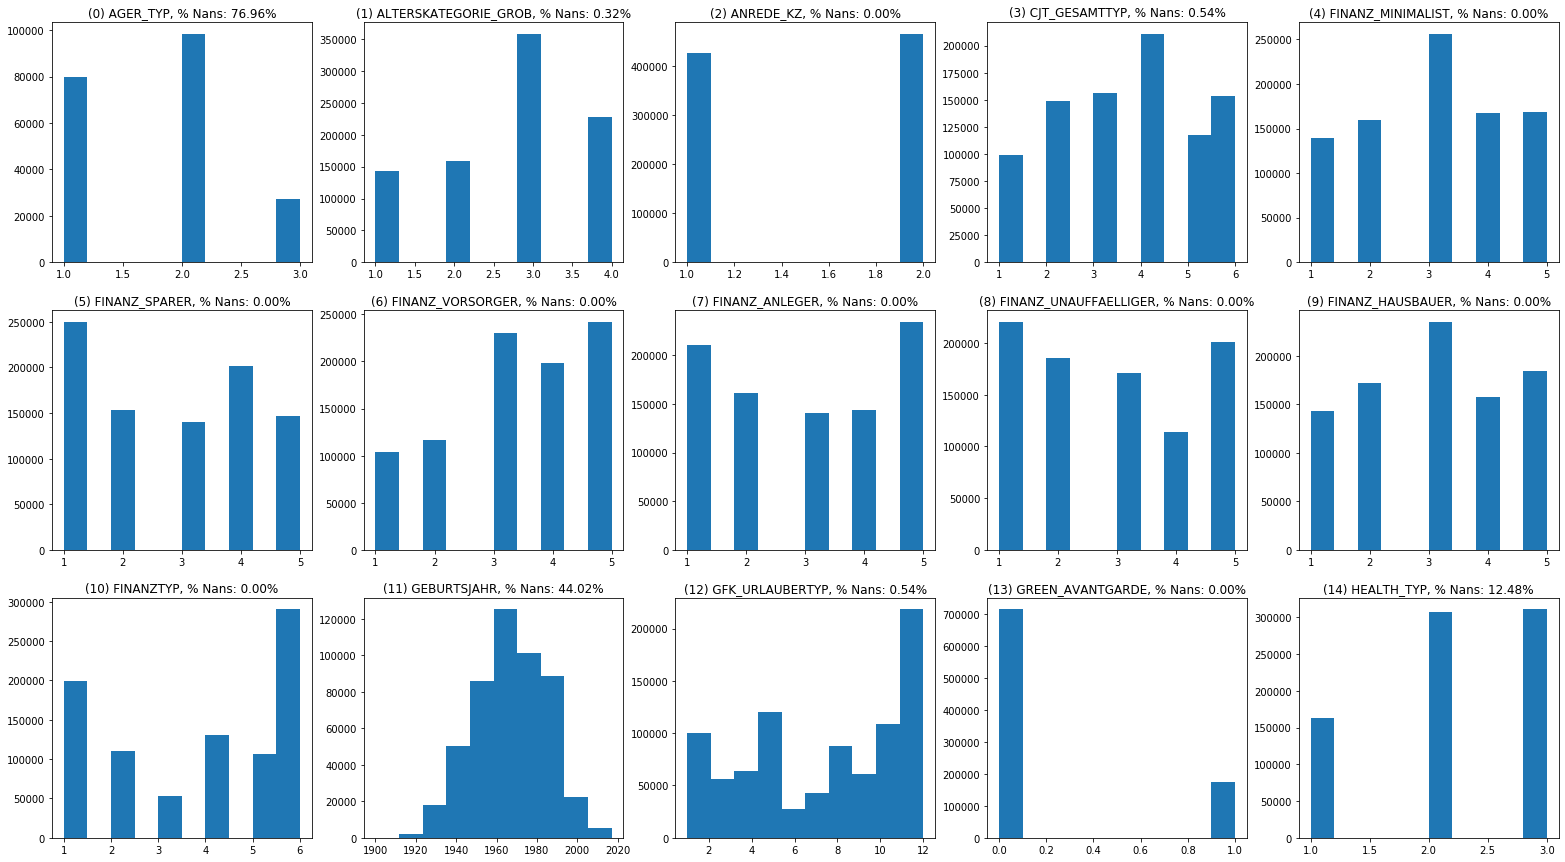

In [11]:
# Call function 'dataframe_hist to investigate distribution per feature'
# Columns selectioned present missing values per column greater than 70%
# interesting_cols = [0, 39, 40, 43, 47, 64, 79]
interesting_cols = range(0,15)
dataframe_hist(df , 3, 5, interesting_cols)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

### Result:
After investigate the dataset, it was possible to identify 3 features with very high rate of missing values (outliers), which will be dropped:

- Features to drop, high percentage of missing data: 
 - 'AGER_TYP', 76.96% 
 - 'TITEL_KZ', 99.76% 
 - 'KK_KUNDENTYP', 65.60%
 
- In addition, many columns require imputation even though they have less percentage of missing values. indexes: [1, 3, 12, 14-23, 38, 39, 41, 46, 49, 51 60-63, 66-84  ]
- Moreover, some features with mixed data type require more investigation since they were not possible to check with Histogram.

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
def remove_features(df_dataset, cols_to_drop ):
    print('Shape before remove columns ', df_dataset.shape)
    # Drop 10 columns according to mentioned before.
    
    df_dataset = df_dataset.drop(columns= cols_to_drop)
    print('columns removed = ', len(cols_to_drop))    
    print('shape "dataset" dataframe after columns removed: ', df_dataset.shape)
    
    return df_dataset
    
df = remove_features(df, cols_to_drop = ['AGER_TYP','TITEL_KZ','KK_KUNDENTYP'])

Shape before remove columns  (891221, 85)
columns removed =  3
shape "dataset" dataframe after columns removed:  (891221, 82)


In [13]:
count_nulls(df, 0.65,'All')

  Feature                   No NaNs   NaNs      Total     % NaNs    Drop      
-----------------------------------------------------------------
 0 ALTERSKATEGORIE_GROB      888,340     2,881   891,221   00.32%    No  
 1 ANREDE_KZ                 891,221         0   891,221   00.00%    No  
 2 CJT_GESAMTTYP             886,367     4,854   891,221   00.54%    No  
 3 FINANZ_MINIMALIST         891,221         0   891,221   00.00%    No  
 4 FINANZ_SPARER             891,221         0   891,221   00.00%    No  
 5 FINANZ_VORSORGER          891,221         0   891,221   00.00%    No  
 6 FINANZ_ANLEGER            891,221         0   891,221   00.00%    No  
 7 FINANZ_UNAUFFAELLIGER     891,221         0   891,221   00.00%    No  
 8 FINANZ_HAUSBAUER          891,221         0   891,221   00.00%    No  
 9 FINANZTYP                 891,221         0   891,221   00.00%    No  
10 GEBURTSJAHR               498,903   392,318   891,221   44.02%    No  
11 GFK_URLAUBERTYP           886,367     

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# Divide dataframe 'azdias' in 2 dataframes:
# below_threshold -> Dataframe including all the rows with missing values below the threshold 
# above_threshold -> Dataframe including all the rows with missing values above the threshold

def split_dataset_threshold(df_dataset, threshold):
    
    print('Threshold, rows containing >= {} Nan values): '.format(threshold))
    thresh_no_nan = df_dataset.shape[1] - threshold
    below_threshold = df_dataset.dropna(thresh = thresh_no_nan)
    above_threshold = df_dataset.loc[~df_dataset.index.isin(df_dataset.dropna(thresh = thresh_no_nan).index)]

    print('(ABOVE) missing values >= {}, Rows: {:8,}'.format(threshold, above_threshold.shape[0]))
    print('(BELOW) missing values < {}, Rows: {:8,}'.format(threshold, below_threshold.shape[0]))
    print('Total Rows: {:8,}'.format(above_threshold.shape[0] + below_threshold.shape[0]))
    
    return below_threshold, above_threshold
    
df, above_threshold = split_dataset_threshold(df, 5)
print('New Dataset is below_threshold shape: ', df.shape)

Threshold, rows containing >= 5 Nan values): 
(ABOVE) missing values >= 5, Rows:  192,064
(BELOW) missing values < 5, Rows:  699,157
Total Rows:  891,221
New Dataset is below_threshold shape:  (699157, 82)


In [15]:
# compare a column distribution in 2 dataframes with same data dictionary
# dataframe1: Panda dataframe containing the data to plot
# dataframe2: Panda dataframe containing the data to plot
# col_num: vector with columns numbers to plot

def barchart_category(df1, df2, col_names, title_df1, title_df2):
    sns.set(style="darkgrid")
    num_charts = len(col_names)
    plt.figure(figsize=(25, 3.5 * num_charts))
    i = 1
    columns = 4
    rows = math.ceil(num_charts * 2 / columns)    
    for e in col_names:
        plt.subplot(rows, columns, i)
        plt.title(title_df1)
        ax = sns.countplot(df1[e], data=df1)
        i += 1
        plt.subplot(rows, columns, i)
        plt.title(title_df2)
        ax1 = sns.countplot(df2[e], data=df2)
        i += 1

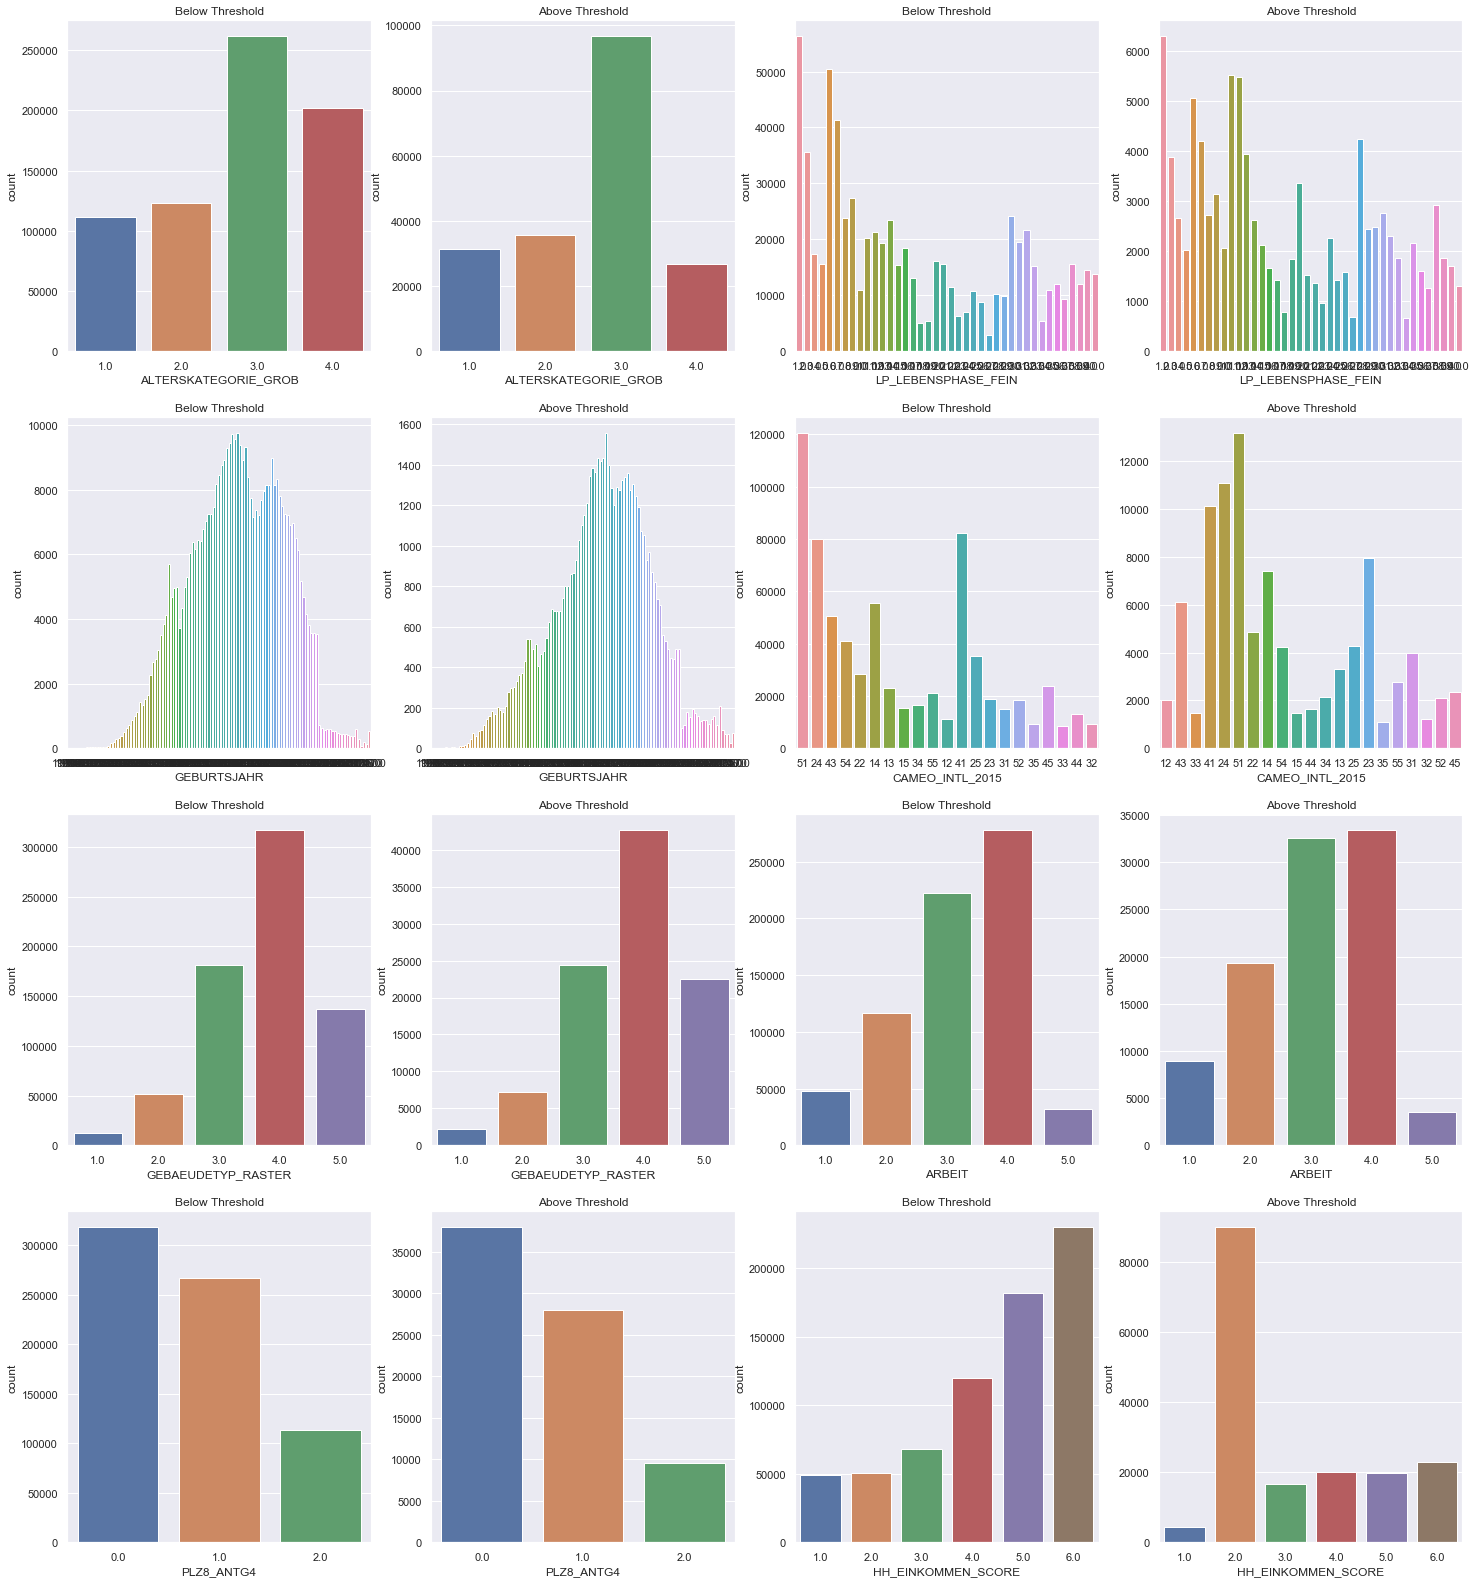

In [16]:
barchart_category(df, above_threshold, title_df1 = 'Below Threshold', title_df2='Above Threshold',
                  col_names = ['ALTERSKATEGORIE_GROB', 'LP_LEBENSPHASE_FEIN', 'GEBURTSJAHR', 'CAMEO_INTL_2015',
                                                              'GEBAEUDETYP_RASTER', 'ARBEIT', 'PLZ8_ANTG4', 'HH_EINKOMMEN_SCORE',])


#### Discussion 1.1.3: Assess Missing Data in Each Row

#### Answer:

The threshold applied was 5 (rows with >= 5 Nans values) which means 2 dataframes created with the following percentages of data:

 - (ABOVE threshold) missing values >= 5, Rows:  192,064 (21.55%)
 - (BELOW threshold) missing values < 5, Rows:  699,157 (78.44%)

Total Rows:  891,221

Observations:
1) At least 21% of the rows contains 5 or more missing values, which is a lot of data missing.  
2) When comparing both datasets (above, below), the distribution of the categories does not look so bad, in fact the bar charts are very similar.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

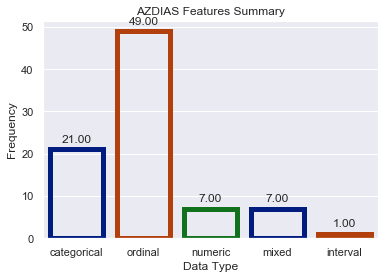

In [17]:
# How many features are there of each data type?
feat_info.type
ax = sns.countplot(x='type', data=feat_info,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3)
                  )

plt.title('AZDIAS Features Summary')
plt.xlabel('Data Type')
plt.ylabel('Frequency')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')



#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


# function: print_column_info()
# description: Print on screen columns information in 'df' using feat_info.
    
# df: dataframe to investigate info
# df_types: dataframe containing data types for each column in df
# feature: Name of column in df_types to extract data type
# data_type: Type of data to investigate


def print_column_info(df, df_types, feature, data_type ):
    print('{:30}{}\t{}\t{} '.format('Column Name','Type','Num of Cat','Values'))
    print('------------------------------------------------------------------')
    i = 0
    cat =''
    for index, row in df_types.iterrows():
        if row.type == data_type:            
            try:
                cat = df[row.attribute].dropna().unique()
                print('{:25}  {}\t{}\t\t{} '.format(row.attribute, data_type, len(cat), cat))
                i += 1
            except:
                continue
        
    print('------------------------------------------------------------------')
    print('Total columns by type: ',i)
    

print_column_info(df, feat_info, feature = 'attribute', data_type = 'categorical')

Column Name                   Type	Num of Cat	Values 
------------------------------------------------------------------
ANREDE_KZ                  categorical	2		[2 1] 
CJT_GESAMTTYP              categorical	6		[5. 3. 2. 4. 1. 6.] 
FINANZTYP                  categorical	6		[1 5 2 4 6 3] 
GFK_URLAUBERTYP            categorical	12		[10.  5.  1. 12.  9.  3.  8. 11.  4.  7.  2.  6.] 
GREEN_AVANTGARDE           categorical	2		[0 1] 
LP_FAMILIE_FEIN            categorical	11		[ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.] 
LP_FAMILIE_GROB            categorical	5		[3. 1. 5. 2. 4.] 
LP_STATUS_FEIN             categorical	10		[ 2.  3.  4.  1. 10.  9.  5.  8.  6.  7.] 
LP_STATUS_GROB             categorical	5		[1. 2. 5. 4. 3.] 
NATIONALITAET_KZ           categorical	3		[1. 2. 3.] 
SHOPPER_TYP                categorical	4		[3. 2. 0. 1.] 
SOHO_KZ                    categorical	2		[1. 0.] 
VERS_TYP                   categorical	2		[2. 1.] 
ZABEOTYP                   categorical	6		[5 4 1 6 3 2] 
G

In [19]:
# Re-encode categorical variable(s) to be kept in the analysis.
# All the categorial variables I showed in previous cell will be encoded even the binary features since 'OST_WEST_KZ' contains only
# 2 values, it is two characters which need to be converted to numeric for modelling later.

# One hot encode for all categorical variables. The function returns the original dataframe concat with one hot columns.
# Also, original columns encoded are dropped for the encoded feature.

def encode_categorical(df_dataset, df_feature_summary, feature):
    i = 0

    print('{:25}\t{:10}'.format('Feature', '#Columns Encoded'))
    print('----------------------------------------------------')
    for c in df_dataset.columns:        
        r = df_feature_summary[df_feature_summary[feature] == c]
        r = r.iloc[0,2]    
        if r == 'categorical':
            df_encoded = pd.get_dummies(df_dataset[c], prefix = c)
            df_dataset = pd.concat([df_dataset, df_encoded ], axis=1)
            df_dataset = df_dataset.drop(c, axis=1)
            print('{:25}\t{:10}'.format(c, df_encoded.shape[1]))
            i += df_encoded.shape[1]
    print('Total Columns: ', i)
 
    return df_dataset



df = encode_categorical(df, feat_info, feature = 'attribute')
print('Dataset New Shape: ', df.shape)
df.head()


Feature                  	#Columns Encoded
----------------------------------------------------
ANREDE_KZ                	         2
CJT_GESAMTTYP            	         6
FINANZTYP                	         6
GFK_URLAUBERTYP          	        12
GREEN_AVANTGARDE         	         2
LP_FAMILIE_FEIN          	        11
LP_FAMILIE_GROB          	         5
LP_STATUS_FEIN           	        10
LP_STATUS_GROB           	         5
NATIONALITAET_KZ         	         3
SHOPPER_TYP              	         4
SOHO_KZ                  	         2
VERS_TYP                 	         2
ZABEOTYP                 	         6
GEBAEUDETYP              	         7
OST_WEST_KZ              	         2
CAMEO_DEUG_2015          	         9
CAMEO_DEU_2015           	        44
Total Columns:  138
Dataset New Shape:  (699157, 202)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1,5,2,5,4,5,1996.0,3.0,21.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,4,1,2,3,5,1979.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,4,3,4,1,3,2,1963.0,3.0,32.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,3,1,5,2,2,5,1943.0,3.0,8.0,...,0,0,0,1,0,0,0,0,0,0
6,2.0,1,5,1,5,4,3,NaN,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

In this step, I decided to keep all categorical features and encode them giving the chance to PCA analysis make a good reduction. Note that always is the option to go back a make adjustment in this analysis if good performance of our cluster model and PCA is not reached.

Moreover, features 'CAMEO_DEUG_2015' and 'CAMEO_DEU_2015' are good candidates to drop due to the quantity of categories (9, 44) which could be a obstacle to PCA when finding a good linear relation, but for now I want to keep them and see what are the results.

In addition, I used get_dummies() function to create one_hot_encoding features. One of my bigest concern with the dataset is the quantity of missing values which represent a big portion of the data. So, I will focus to make decision rather to drop some rows or impute them without altering or biasing the results.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [20]:
print_column_info(df, feat_info, feature = 'attribute', data_type = 'mixed')

Column Name                   Type	Num of Cat	Values 
------------------------------------------------------------------
LP_LEBENSPHASE_FEIN        mixed	40		[21.  3. 32.  8.  2.  5. 10.  4.  6. 20.  1. 25. 13. 18. 31. 38. 35. 30.
  7. 22. 14. 29. 24. 37. 26. 12. 39. 27. 36.  9. 34. 33. 15. 11. 40. 16.
 19. 23. 28. 17.] 
LP_LEBENSPHASE_GROB        mixed	12		[ 6.  1. 10.  2.  3.  5.  7. 12. 11.  9.  4.  8.] 
PRAEGENDE_JUGENDJAHRE      mixed	15		[14. 15.  8.  3. 10. 11.  9.  6.  4.  5.  2.  1. 12. 13.  7.] 
WOHNLAGE                   mixed	8		[4. 2. 3. 7. 5. 1. 8. 0.] 
CAMEO_INTL_2015            mixed	21		['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '12' '41' '25' '23'
 '31' '52' '35' '45' '33' '44' '32'] 
KBA05_BAUMAX               mixed	5		[5. 1. 2. 3. 4.] 
PLZ8_BAUMAX                mixed	5		[1. 2. 4. 5. 3.] 
------------------------------------------------------------------
Total columns by type:  7


In [21]:
# FEATURE ENGINEERING FOR "PRAEGENDE_JUGENDJAHRE"
# takes feature "PRAEGENDE_JUGENDJAHRE", then create 2 columns according to the following codification:
'''
Decoding 'DECADES'
Type: Interval
40 -> 1,2
50 -> 3,4
60 -> 5,6,7
70 -> 8,9
80 -> 10,11,12,13
90 -> 14,15

Decoding 'MOVEMENT'
Type: Binary
0 -> avantgarde (2,4,6,7,9,11,13,15)
1 -> mainstream (1,3,5,8,10,12,14)

'''
def decoding_praegende(row):
    dict = {'1':[40,1], '2':[40,0], '3':[50,1], '4':[50,0], '5':[60,1], '6':[60,0], '7':[60,0], '8':[70,1], '9':[70,0],
            '10':[80,1], '11':[80,0],'12':[80,1], '13':[80,0], '14':[90,1], '15':[90,0] }
#     print('row: ',row)
    
    if np.isnan(row):
        decade = np.nan
        movement = np.nan
    else:
        row = str(int(row))
        decade = dict[row][0]
        movement = dict[row][1]
    
    return decade, movement

def split_praegende(df):
    serie_tuple = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda row: decoding_praegende(row))
    df = pd.concat([df, pd.DataFrame(serie_tuple.tolist(), columns=['DECADES','MOVEMENT'], index=serie_tuple.index)], axis=1)
    
    # Drop feature 'PRAEGENDE_JUGENDJAHRE' which is not meaning anymore since we extracted the data in previous step
    df.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace = True)
    
    return df

df = split_praegende(df)
print('New Dataset is {:12}, shape: {}'.format('df_encoded', df.shape))

New Dataset is df_encoded  , shape: (699157, 203)


In [22]:
# FEATURE ENGINEERING FOR "CAMEO_INTL_2015"
# takes feature "CAMEO_INTL_2015", then create 2 columns according to the following codification:
'''
-----------------------------------------
Decoding 'WEALTH'
Type: Ordinal, (First digit)
11 -> 1
12 -> 1
13 -> 1
.
.
.
55 -> 5
-----------------------------------------
Decoding 'LIFE_STAGE'
Type: Ordinal, (Second digit)
11 -> 1
12 -> 2
13 -> 3
.
.
.
55 -> 5
-----------------------------------------
'''
def decoding_cameo_intl(row):

#     print(row, type(row))
   
    try:
        if np.isnan(row):
            wealth = np.nan
            life_stage = np.nan   
    except:        
        row = str(row)
        wealth = int(row[0])
        life_stage = int(row[1])
   
    return wealth, life_stage

def split_cameo_intl(df):
    serie_tuple = df['CAMEO_INTL_2015'].apply(lambda row: decoding_cameo_intl(row))
    df = pd.concat([df, pd.DataFrame(serie_tuple.tolist(), columns=['WEALTH','LIFE_STAGE'], index=serie_tuple.index)], axis=1)
    
    # Drop feature 'CAMEO_INTL_2015' which is not meaning anymore since we extracted the data in previous step
    df.drop(columns='CAMEO_INTL_2015', inplace = True)

    return df

df = split_cameo_intl(df)
print('New Dataset is {:12}, shape: {}'.format('df_encoded', df.shape))

New Dataset is df_encoded  , shape: (699157, 204)


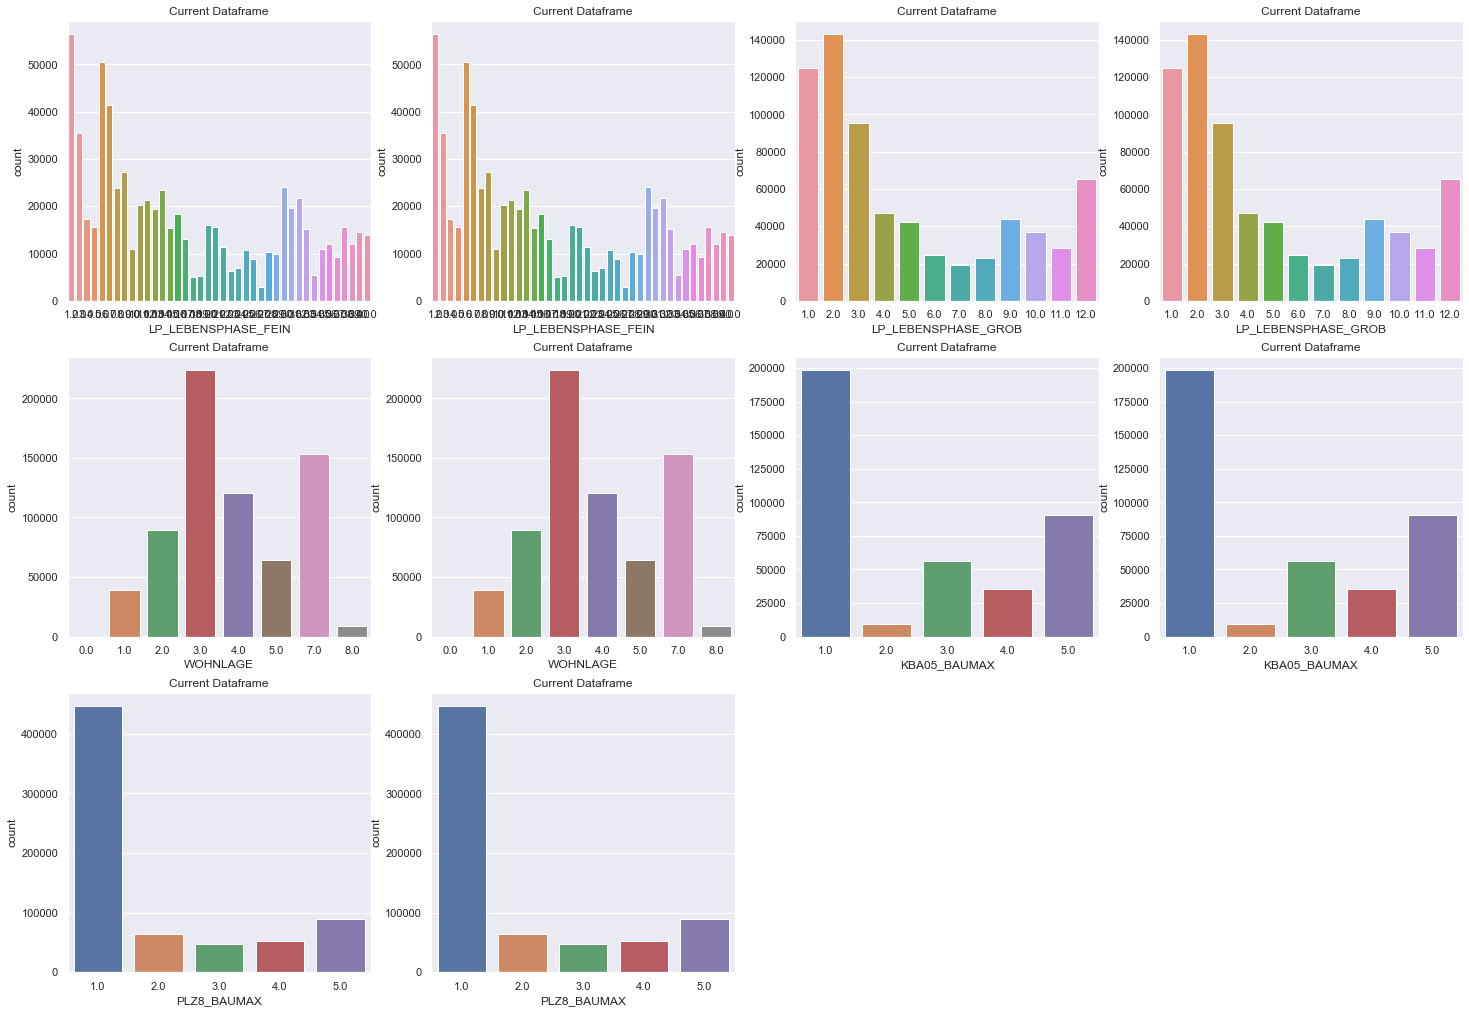

In [23]:
barchart_category(df, df, title_df1='Current Dataframe', title_df2='Current Dataframe',
                  col_names = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE',
                                                              'KBA05_BAUMAX', 'PLZ8_BAUMAX'])


In [24]:
# Drop columns 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE','KBA05_BAUMAX', 'PLZ8_BAUMAX'])
df = remove_features(df, cols_to_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE','KBA05_BAUMAX', 'PLZ8_BAUMAX'])

Shape before remove columns  (699157, 204)
columns removed =  5
shape "dataset" dataframe after columns removed:  (699157, 199)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I decided to drop the rest of 'mixed' features because the following reasons:

- LP_LEBENSPHASE_FEIN ( Denotating Life stage, fine scale):
It can take 40 different values which could introduce noise to the model avoiding it to learn patterns. I don't see how this variable can help the model to generalize. I decided to drop this feature.

- LP_LEBENSPHASE_GROB ( Denotating Life stage, rough scale):
Same information than 'LP_LEBENSPHASE_FEIN', but in rought scale. 

- WOHNLAGE (Denotating information about neighbors)
No useful for the analysis

- KBA05_BAUMAX (Most common building type within the microcell)
It does not look like important information about the people, more detail should be necessary to understand what they are measuring with 'microcell'. For now, it will be dropped.

- PLZ8_BAUMAX (Most common building type within the PLZ8 region)
This features is more about the type of building by region. It will be dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print('Mixed Features:')
print_column_info(df, feat_info, feature = 'attribute', data_type = 'mixed')
print('******************************************************************************\n\n')
print('Categorical Features:')
print_column_info(df, feat_info, feature = 'attribute', data_type = 'categorical')
print('******************************************************************************\n\n')
print('Numeric Features:')
print_column_info(df, feat_info, feature = 'attribute', data_type = 'numeric')
print('******************************************************************************\n\n')
print('Ordinal Features:')
print_column_info(df, feat_info, feature = 'attribute', data_type = 'ordinal')
print('******************************************************************************\n\n')
print('Interval Features:')
print_column_info(df, feat_info, feature = 'attribute', data_type = 'interval')


Mixed Features:
Column Name                   Type	Num of Cat	Values 
------------------------------------------------------------------
------------------------------------------------------------------
Total columns by type:  0
******************************************************************************


Categorical Features:
Column Name                   Type	Num of Cat	Values 
------------------------------------------------------------------
------------------------------------------------------------------
Total columns by type:  0
******************************************************************************


Numeric Features:
Column Name                   Type	Num of Cat	Values 
------------------------------------------------------------------
GEBURTSJAHR                numeric	115		[1996. 1979. 1963. 1943. 1964. 1974. 1975. 1941. 1966. 1949. 1982. 1957.
 1972. 1990. 1985. 1989. 1948. 1935. 1997. 1988. 1994. 1987. 2002. 1950.
 1978. 1958. 1944. 1967. 1977. 1960. 1970. 1973

## Features Summary:

1) Categorical: 0  
2) Mixed 0  
3) Numeric: 7  
4) Ordinal: 49  
5) Categorical to One Hot Encoding: 138  
6) Mixed to (Interval, Ordinal): 4  
7) Interval: 1  

Total Features: 199, which corresponds to the number of columns obtained after dropped the 'mixed' features discarded for the analysis.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [26]:
def clean_data(df_dataset, df_feature_summary ):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    print('\n\n>>Dataset Original Shape: ', df_dataset.shape)
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_dataset = unknown_to_nan(df_dataset, df_feature_summary)
    print('\n\n>>Converting Missing to Nans New Shape: ', df_dataset.shape)
    
    # remove selected columns and rows, ...
    df_dataset = remove_features(df_dataset, cols_to_drop = ['AGER_TYP','TITEL_KZ','KK_KUNDENTYP'])
    df_dataset, above_threshold = split_dataset_threshold(df_dataset, 5) # df_dataset -> less than 5 values Nan per row
    print('\n\n>>Removing rows and cols New Shape: ', df_dataset.shape)
    
    # select, re-encode, and engineer column values.
    df_dataset = encode_categorical(df_dataset, feat_info, feature = 'attribute')
    print('\n\n>>One Hot Encoding New Shape: ', df_dataset.shape)
    
    df_dataset = split_praegende(df_dataset)
    df_dataset = split_cameo_intl(df_dataset)
    df_dataset = remove_features(df_dataset, cols_to_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE','KBA05_BAUMAX', 'PLZ8_BAUMAX'])
    print('\n\n>>decoding Mixed, New Shape: ', df_dataset.shape)

    
    # Return the cleaned dataframe.
    return df_dataset    

In [27]:
df1 = clean_data(azdias, feat_info)



>>Dataset Original Shape:  (891221, 85)
Feature                   Found Value          Rows           Replaced
------------------------------------------------------------------------
AGER_TYP                  Value -1, Found        0, Replaced        0
AGER_TYP                  Value  0, Found        0, Replaced        0
ALTERSKATEGORIE_GROB      Value -1, Found        0, Replaced        0
ALTERSKATEGORIE_GROB      Value  0, Found        0, Replaced        0
ALTERSKATEGORIE_GROB      Value  9, Found        0, Replaced        0
ANREDE_KZ                 Value -1, Found        0, Replaced        0
ANREDE_KZ                 Value  0, Found        0, Replaced        0
CJT_GESAMTTYP             Value  0, Found        0, Replaced        0
FINANZ_MINIMALIST         Value -1, Found        0, Replaced        0
FINANZ_SPARER             Value -1, Found        0, Replaced        0
FINANZ_VORSORGER          Value -1, Found        0, Replaced        0
FINANZ_ANLEGER            Value -1, Found   

In [28]:
# Shape comprobation
print('>>Original Dataset Shape: ', azdias.shape)
print('Resulting Dataset using data_clean() function: ', df1.shape)
print('Resulting Dataset performing steps in this pipeline: ' , df.shape)

>>Original Dataset Shape:  (891221, 85)
Resulting Dataset using data_clean() function:  (699157, 199)
Resulting Dataset performing steps in this pipeline:  (699157, 199)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Check for Nan values by Column
count_nulls(df, 0.6, 'Nulls')

  Feature                   No NaNs   NaNs      Total     % NaNs    Drop      
-----------------------------------------------------------------
 0 ALTERSKATEGORIE_GROB      697,889     1,268   699,157   00.18%    No  
 7 GEBURTSJAHR               439,140   260,017   699,157   37.19%    No  
 8 HEALTH_TYP                687,864    11,293   699,157   01.62%    No  
24 ALTER_HH                  510,040   189,117   699,157   27.05%    No  
28 W_KEIT_KIND_HH            675,814    23,343   699,157   03.34%    No  
30 ANZ_HAUSHALTE_AKTIV       696,753     2,404   699,157   00.34%    No  
31 ANZ_HH_TITEL              698,639       518   699,157   00.07%    No  
32 KONSUMNAEHE               699,119        38   699,157   00.01%    No  
39 BALLRAUM                  698,790       367   699,157   00.05%    No  
40 EWDICHTE                  698,790       367   699,157   00.05%    No  
41 INNENSTADT                698,790       367   699,157   00.05%    No  
42 GEBAEUDETYP_RASTER        699,154     

In [30]:
# Drop all rows with Nans values and check the dataset after that.
df1 = df.dropna()
count_nulls(df1, 0.6, 'Nulls')
print(df1.shape)

  Feature                   No NaNs   NaNs      Total     % NaNs    Drop      
-----------------------------------------------------------------
(348159, 199)


In [31]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df1)
X.shape

(348159, 199)

### Discussion 2.1: Apply Feature Scaling

My first intention was to fill out the Nans values using KNNimputer from sklearn. However, it was some issues with memory capacity that I could not fix. Then, I decided to drop all rows containing Nans to obtain a final dataset with shape (348159, 199). After that, I applied StandardScaler() to scale all values between 0 and 1 to prepare and help them fitting in my PCA analysis and final clustering algorithm.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [32]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

def perform_pca(X, n_comp):
    pca = PCA(n_comp)
    X_pca = pca.fit_transform(X)

    return pca, X_pca

In [ ]:
# results = []
# num_comp = []
# for i in range(60,199):
#     pca, X_pca = perform_pca(X, i)
#     cum_val = sum(pca.explained_variance_ratio_)
#     num_comp.append(i)
#     results.append(cum_val)
#     if cum_val > 0.9:
#         break

In [ ]:
# Vector of Maximal variance in data
# pca_weights = pca.components_
# print('Shape Vector Maximum Variance in Data: ', pca_weights.shape, '\nVector: ', pca_weights)

In [ ]:
#  Plot Variance explained by number of Components
# plt.figure(figsize=(10, 6))
# ax = plt.subplot(111)

# ax.plot(num_comp, results)
# ax.set_xlabel("Number of Component")
# ax.set_ylabel("Variance Explained (%)")
# plt.title('Explained Variance Per n Number of Components')

In [33]:
def comp_plot(pca):
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    
    vals = pca.explained_variance_ratio_
    len_num_comp = len(vals)
    ind = np.arange(len_num_comp)    

    ax.bar(ind, vals)

    for i in range(len_num_comp):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.set_xlabel("Number of Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Ratio of Variance Explained Per Component')

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = perform_pca(X, 102)


0.9027653876564592


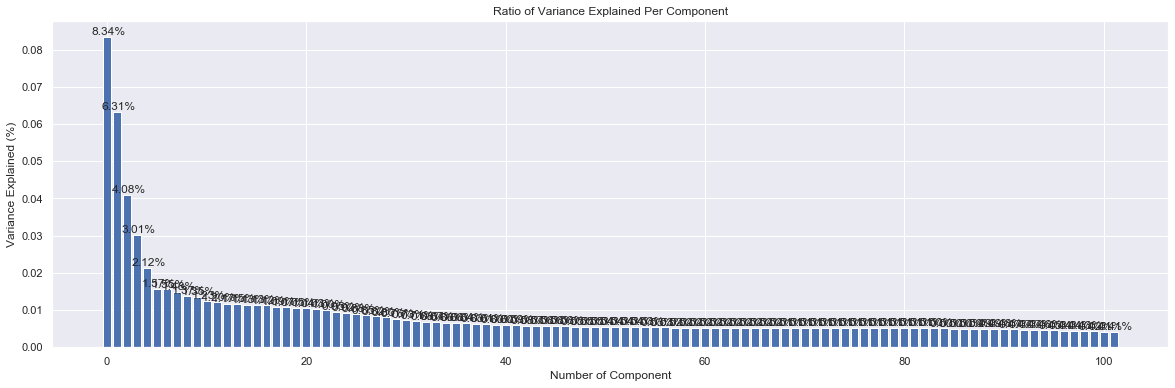

In [35]:
print(sum(pca.explained_variance_ratio_))
comp_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

- I found that 102 components explains 90% of variance in the dataset
- The component with more influence explains 11.2%
- The first 23 components contains a ratio greater than 1%, while the rest showed a very little ratio less than 1%.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [36]:
# pca: Component to investigate
# ranking: Rank of features with more variance explained
# comp_num: Component Number to investigate, index of component vector
# column_names: Vector with columns names to map

def feature_weights(pca, ranking, comp_num, column_names):
    
    # print(pca_shape)
#     pca_shape = pca_weights.shape
    pca_weights = pca.components_    
    component = pca_weights[comp_num,:]    
    component = component.reshape(pca_weights.shape[1],1)
#     print('Component Shape:', component.shape)

    # Convert Columns to numpy and reshape it to (199,1)
    cols = np.array(column_names).reshape(pca_weights.shape[1],1)
#     print('Columns Names Shape:', cols.shape)

    # Merge columns names with weights
    merge_data = np.hstack((cols, component))
    print('Data Merged Shape: ', merge_data.shape, type(merge_data))

    # sort data and extract ranking of features with more weight
    ranked = np.argsort(abs(merge_data[:,1]))
    ind = ranked[::-1][:ranking]
    
    result = np.array([])
    
    for i in ind:
#         print(merge_data[i])
        result = np.append(result, merge_data[i])
    result = result.reshape(ranking, 2)    
    return result

# ---------------------------------------------------------
# Screen a bar plot to show feature importance by component
def comp_bar_plot(comp):
    
    plt.figure(figsize=(17, 6))
    plt.subplot()
    len_comp = len(comp)
    ind = np.arange(len_comp)
    vals = comp[:,1]

    for i in range(len_comp):
        plt.barh(i, comp[i,1])
        if comp[i,1] > 0: p=-0.1
        else: p=0.1
        plt.annotate('{}, val={:2.2f}'.format(comp[i,0],vals[i]), xy=(comp[i,1]+p,i),
                    xytext=(comp[i,1],i),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
    plt.legend(comp[:,0])
    plt.ylabel("Feature Ranking, 0: Most Important")
    plt.xlabel("Feature Weight")
    plt.title('Feature Importance by Component')


Data Merged Shape:  (199, 2) <class 'numpy.ndarray'>
[['MOBI_REGIO' -0.19685400550339285]
 ['FINANZ_MINIMALIST' -0.1917101898311701]
 ['LP_STATUS_GROB_1.0' 0.18994367782635252]
 ['KBA05_ANTG1' -0.18577212983354882]
 ['HH_EINKOMMEN_SCORE' 0.18055851465625622]
 ['WEALTH' 0.17687058723996185]]


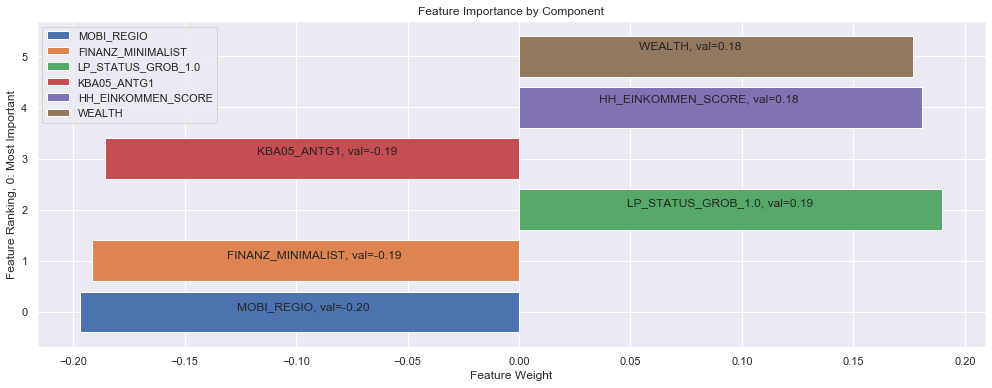

In [37]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


# First Component
f = feature_weights(pca, ranking=6, comp_num=0, column_names=df1.columns)
print(f)
comp_bar_plot(f)

Data Merged Shape:  (199, 2) <class 'numpy.ndarray'>
[['GEBURTSJAHR' -0.23131992693385162]
 ['DECADES' -0.22567753216791317]
 ['ALTER_HH' -0.21898058495607034]
 ['ALTERSKATEGORIE_GROB' 0.2070033075959102]
 ['FINANZ_SPARER' -0.20585440274070432]
 ['FINANZ_UNAUFFAELLIGER' -0.19916307510090558]]


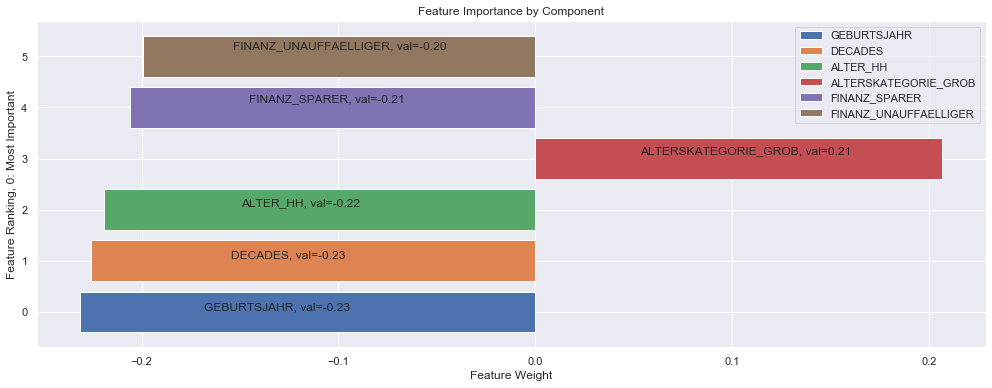

In [38]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Second Component
f = feature_weights(pca, ranking=6, comp_num=1, column_names=df1.columns)
print(f)
comp_bar_plot(f)

Data Merged Shape:  (199, 2) <class 'numpy.ndarray'>
[['ANREDE_KZ_1' 0.3285741037333424]
 ['ANREDE_KZ_2' -0.3285741037333424]
 ['SEMIO_VERT' 0.30060293467744154]
 ['SEMIO_KAEM' -0.300050636537426]
 ['SEMIO_DOM' -0.26638816196873877]
 ['SEMIO_FAM' 0.2519043076394753]]


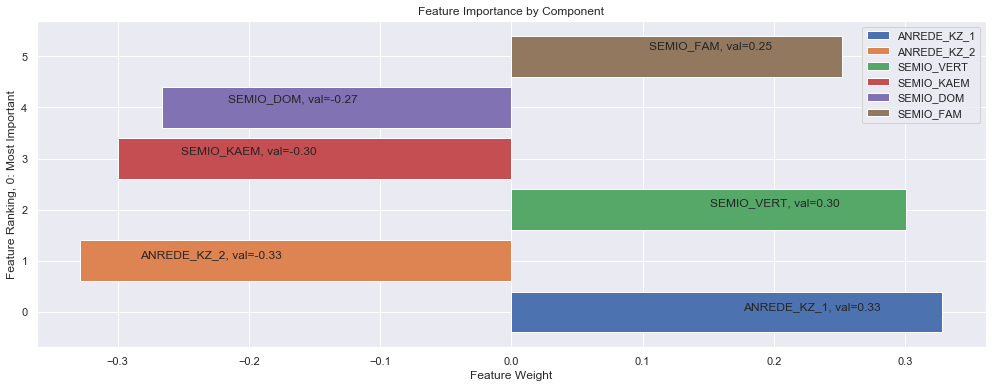

In [39]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Third Component
f = feature_weights(pca, ranking=6, comp_num=2, column_names=df1.columns)
print(f)
comp_bar_plot(f)

### Discussion 2.3: Interpret Principal Components

# TO REVIEW ******************

My previous analysis showed plots of the 6 most important eigenvalues for first three components or eigenvectors. The most representative observation some annotated as follow:  
- First Component:  
  -  There are 3 positive correlated features (LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE, WEALTH) whereas (MOBI_REGIO, FINANZ_MINIMALIST, KBA05_ANTG1) are negatively correlated. The weights of these 6 features are very low, all of them range between 0 and 0.18 for positives values ,and 0 to -0.20 for negatives. Here I can conclude that the weights for this components are spread out throught all 199 variables since top 6 eigenvalues are low.<br><br>  
- Second Component:  
 
   - This component presents 5 out of 6 features with negative values being GEBURTSJAHR (Year of birth) the weightest feature. The values in this component are higher than first component but no too much to show a markable influence for any feature.
<br><br>
- Third Component:
  - The values start to be more representative since it showed values greater than 0.3. The weightest features are ANREDE_KZ_2, ANREDE_KZ_1 which correspond to 'Gender'. Note that these 2 eigenvalues are opposite in sign but equal in value. So, they influence the variance explained for this component negatively (ANREDE_KZ_2, 'Female') and positively for (ANREDE_KZ_1, 'male').

In general, with this analysis I am able to see how every feature helps the component to explain the variance in the original dataset.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [40]:
def time_conversion(s, e):
    delta_time = e -s
    delta_min = delta_time / 60
    delta_hour = delta_min / 60
    print('{:2.2f} Seg, {:2.2f} Min, {:2.2f} Hours'.format(delta_time, delta_min , delta_hour))
    
        

In [45]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import time

s_time = time.time()


# run k-means clustering on the data and...
silhouette = []
scores = []
ssd = []
start = 10
end = 32

# Try a range of k cluster and calculates 3 metrics (score, sum square distance and silhouette score)
for k in range(start,end,2):
    print('k = ', k, end=' ')
    km = MiniBatchKMeans(k, random_state=42, batch_size=50).fit(X_pca)
    scores.append(abs(km.score(X_pca)))
    ssd.append(km.inertia_)  
    silhouette.append(silhouette_score(X_pca, km.labels_))
    e_time = time.time()
    time_conversion(s_time, e_time)


k =  10 3817.32 Seg, 63.62 Min, 1.06 Hours
k =  12 7516.20 Seg, 125.27 Min, 2.09 Hours
k =  14 11201.42 Seg, 186.69 Min, 3.11 Hours
k =  16 14885.97 Seg, 248.10 Min, 4.13 Hours
k =  18 18579.60 Seg, 309.66 Min, 5.16 Hours
k =  20 22259.92 Seg, 371.00 Min, 6.18 Hours
k =  22 25944.51 Seg, 432.41 Min, 7.21 Hours
k =  24 29648.62 Seg, 494.14 Min, 8.24 Hours
k =  26 33390.07 Seg, 556.50 Min, 9.28 Hours
k =  28 37093.70 Seg, 618.23 Min, 10.30 Hours
k =  30 40794.54 Seg, 679.91 Min, 11.33 Hours


In [46]:
print(scores)
print(ssd)
print(silhouette)

[50803322.02021533, 51046451.99197273, 50017879.14395777, 47671325.94490395, 47124259.862117864, 49829352.44930555, 49029734.771470785, 45064187.06461946, 44775405.37785368, 44060200.556982905, 44031298.49062839]
[50803322.02021535, 51046451.99197273, 50017879.143957786, 47671325.94490394, 47124259.86211788, 49829352.449305564, 49029734.771470785, 45064187.06461946, 44775405.37785368, 44060200.556982905, 44031298.49062838]
[0.023769891303267277, 0.027744344132071823, 0.031545934709143984, 0.042234196891678615, 0.04585291676339361, 0.02278951659834899, 0.0084848522572308, 0.05110352717605466, 0.04561290887065603, 0.054116726592029284, 0.055943861612311525]


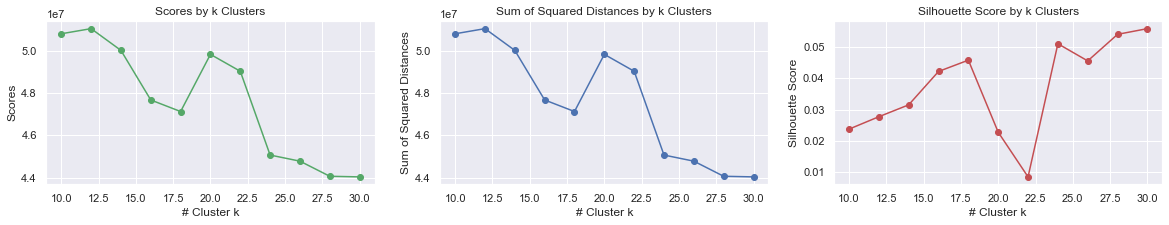

In [48]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

def plot_scores(k, s_scores, s_ssd, s_silhouette ):

    # Plot Score metric
    plt.figure(figsize=(20, 3))
    plt.subplot(1,3,1)
    plt.plot(k, s_scores,'o-', color='g')
    plt.ylabel("Scores")
    plt.xlabel("# Cluster k")
    plt.title('Scores by k Clusters')

    # Plot SSD metric
    plt.subplot(1,3,2)
    plt.plot(k, s_ssd, 'o-', color='b')
    plt.ylabel("Sum of Squared Distances")
    plt.xlabel("# Cluster k")
    plt.title('Sum of Squared Distances by k Clusters')

    # Plot Silhouette Score metric
    plt.subplot(1,3,3)
    plt.plot(k, s_silhouette,'o-', color='r')
    plt.ylabel("Silhouette Score")
    plt.xlabel("# Cluster k")
    plt.title('Silhouette Score by k Clusters')

k = range(start,end,2)
plot_scores(k, scores, ssd, silhouette)

In [49]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import time

s_time = time.time()


# run k-means clustering on the data and...
silhouette1 = []
scores1 = []
ssd1 = []
start = 10
end = 32

# Try a range of k cluster and calculates 3 metrics (score, sum square distance and silhouette score)
for k in range(start,end,2):
    print('k = ', k, end=' ')
    km1 = KMeans(k, random_state=42).fit(X_pca)
    scores1.append(abs(km1.score(X_pca)))
    ssd1.append(km1.inertia_)  
    silhouette1.append(silhouette_score(X_pca, km1.labels_))
    e_time = time.time()
    time_conversion(s_time, e_time)


k =  10 3848.69 Seg, 64.14 Min, 1.07 Hours
k =  12 7664.58 Seg, 127.74 Min, 2.13 Hours
k =  14 11565.12 Seg, 192.75 Min, 3.21 Hours
k =  16 15513.30 Seg, 258.56 Min, 4.31 Hours
k =  18 19493.44 Seg, 324.89 Min, 5.41 Hours
k =  20 23493.68 Seg, 391.56 Min, 6.53 Hours
k =  22 27502.38 Seg, 458.37 Min, 7.64 Hours
k =  24 31540.93 Seg, 525.68 Min, 8.76 Hours
k =  26 36095.20 Seg, 601.59 Min, 10.03 Hours
k =  28 40463.13 Seg, 674.39 Min, 11.24 Hours
k =  30 44559.89 Seg, 742.66 Min, 12.38 Hours


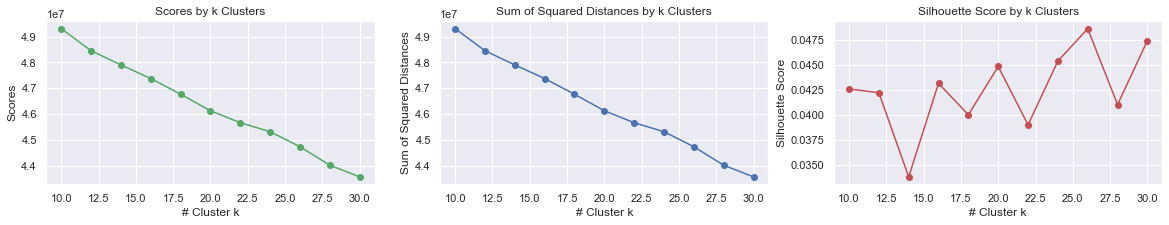

In [50]:
k = range(start,end,2)
plot_scores(k, scores1, ssd1, silhouette1)

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 30
km_dem = KMeans(k, random_state=42).fit(X_pca)
scores_dem = (abs(km_dem.score(X_customers)))
ssd_dem = (km_dem.inertia_)
silhouette_dem = (silhouette_score(X_customers, km_dem.labels_))

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv(Udacity_CUSTOMERS_Subset.csv, sep=';')
print(customers.shape)
customers.head()

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Preprocessing Customer Dataset
df_customers = clean_data(customers, feat_info)

# Shape comprobation
print('>>Original Dataset Shape: ', customers.shape)
print('Resulting Dataset after data_clean() function: ', df_customers.shape)

In [ ]:
# Check for Nan values in Customers Dataset
count_nulls(df_customers, 0.6, 'Nulls')

In [ ]:
# Drop all rows with Nans values and check the dataset after that.
df_customers = df_customers.dropna()
count_nulls(df_customers, 0.6, 'Nulls')
print(df_customers.shape)

In [ ]:
# Create a StandardScaler objet to fit and transform Customers dataset
scaler = StandardScaler()
X_customers = scaler.fit_transform(df_customers)
X_customers.shape

In [ ]:
# Perform PCA
pca, X_pca = perform_pca(X_customers, 102)

In [ ]:
# Plot PCA variance Ratio
comp_plot(pca)

In [ ]:
# Perform Clustering
# run k-means clustering on the data
silhouette = []
scores = []
ssd = []
start = 10
end = 30

k = 

km_cust = KMeans(k, random_state=42).fit(X_customers)
score_cust = (abs(km_cust.score(X_customers)))
ssd_cust = (km_cust.inertia_)
silhouette_cust = (silhouette_score(X_customers, km_cust.labels_))

In [ ]:
ind = range(start,end)

# Plot Score metric
plt.figure(figsize=(17, 8))
# plt.subplot(1,3,1)

plt.bar(0, score_cust)
plt.bar(1, ssd_cust)
plt.bar(2, silhouette_cust)

plt.xticks(0, 'Score')
plt.xticks(1, 'SSD')
plt.xticks(2, 'Silhouette')

plt.annotate('{:2.2f}'.format(score_cust), xy=(0, score_cust+0.3), xytext=(0, score_cust+0.3), textcoords="offset points", ha='center', va='top')
plt.annotate('{:2.2f}'.format(ssd_cust), xy=(0, ssd_cust+0.3), xytext=(0, ssd_cust+0.3), textcoords="offset points", ha='center', va='top')
plt.annotate('{:2.2f}'.format(silhouette_cust), xy=(0, silhouette_cust+0.3), xytext=(0, silhouette_cust+0.3), textcoords="offset points", ha='center', va='top')

plt.ylabel("Scores")
plt.xlabel("Metrics")
plt.title('Metrics for '+ k + ' Clusters Model')

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.